<a href="https://colab.research.google.com/github/Clement-Okolo/Census-Bureau-Project/blob/main/02_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Model: Census Bureau Data

## Objective
Build a customer segmentation model to identify distinct market segments from census data for marketing.

## Business Context
- **Client**: Retail business
- **Goal**: Identify actionable customer segments for tailored marketing strategies
- **Data**: Weighted census data with demographic and employment variables
- **Expected Outcome**: distinct customer segments with clear business value

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Dataset

In [4]:
# Load column names
with open('/content/drive/MyDrive/Colab Notebooks/JPMorgan/census-bureau.columns', 'r') as f:
    columns = [line.strip() for line in f.readlines()]

print(f"Total columns: {len(columns)}")
print("Column names:", columns)

# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JPMorgan/census-bureau.data', names=columns)

print(f"\nDataset shape: {df.shape}")

Total columns: 42
Column names: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 've

The dataset, consisting of 199,523 rows and 42 columns.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

In [6]:
print(f"Missing values: {df.isnull().sum().sum()}")

Missing values: 874


In [7]:
# Separate numeric and categorical columns
numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

In [8]:
print("Numerical Variables:", len(numerical_vars))
print(numerical_vars)
print("\nCategorical Variables:", len(categorical_vars))
print(categorical_vars)

Numerical Variables: 13
['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'weight', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'year']

Categorical Variables: 29
['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birt

## Data Preparation/Cleaning

* The `weight` variable is removed because including it would distort segmentation model because records would be grouped based on their sampling representation rather than actual customer characteristics.

* The `Year` variable is removed because includingit might cause the segmentation model to split customers into "Group 1994" and "Group 1995." This creates segments based on when the data was recorded rather than who the customers are.

* The `label` variable is removed because including it would artificially bias the segmentation model toward income differences, rather than having a natural and independent segmentation from customer characteristics.

Unlike as I did during the classification model development, I will not be dropping the `weeks worked in year` variable. This is beacause it provides a specific temporal dimension of labor that `detailed industry recode` and `detailed industry recode` does not.

In [9]:
# Prepare features for clustering
X_segment = df.drop(['weight', 'year', 'label'], axis=1)

In [10]:
# Get categorical columns that are in X (excluding the dropped features)
categorical_vars_to_encode = [col for col in categorical_vars if col in X_segment.columns]

# One-hot encode categorical variables
X_segment = pd.get_dummies(X_segment, columns=categorical_vars_to_encode, drop_first=False)

print(f"Features: {X_segment.columns.tolist()}")


Features: ['age', 'detailed industry recode', 'detailed occupation recode', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'own business or self employed', 'veterans benefits', 'weeks worked in year', 'class of worker_Federal government', 'class of worker_Local government', 'class of worker_Never worked', 'class of worker_Not in universe', 'class of worker_Private', 'class of worker_Self-employed-incorporated', 'class of worker_Self-employed-not incorporated', 'class of worker_State government', 'class of worker_Without pay', 'education_10th grade', 'education_11th grade', 'education_12th grade no diploma', 'education_1st 2nd 3rd or 4th grade', 'education_5th or 6th grade', 'education_7th and 8th grade', 'education_9th grade', 'education_Associates degree-academic program', 'education_Associates degree-occup /vocational', 'education_Bachelors degree(BA AB BS)', 'education_Children', 'education_Doctorate degree(PhD EdD)', 

After one-hot encoding the features both **"?"**  and **'Not in universe'** placeholders were not dropped, rather they were kept as their own features to capture people who have incomplete profiles, which is a real-world "segment" we might want to understand.

In [11]:
# Handle missing values
X_segment = X_segment.fillna(X_segment.median())

print(f"Missing values after preprocessing: {X_segment.isnull().sum().sum()}")
print(f"Final feature matrix shape: {X_segment.shape}")

Missing values after preprocessing: 0
Final feature matrix shape: (199523, 406)


In [12]:
# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segment)

# Convert back to DataFrame for easier manipulation
X_scaled = pd.DataFrame(X_scaled, columns=X_segment.columns)

print(f"\nFeatures scaled - mean: {X_scaled.values.mean():.4f}, std: {X_scaled.values.std():.4f}")


Features scaled - mean: 0.0000, std: 1.0000


Our dataset contains variables with different scales. Standardization is used to transform all features to have a mean of 0 and a standard deviation of 1, ensuring they the clustering algorithms are not distorted by different units of measurement.

## Determine the Optimal Number of Clusters

In [13]:
# Use Elbow Method to find optimal number of clusters
wcss = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

print("Testing different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=45, n_init=10, init = 'k-means++', max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_, sample_size=10000))
    print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.4f}")

print("\nElbow analysis complete!")

Testing different numbers of clusters...
K=2: WCSS=78663850.61, Silhouette Score=0.0654
K=3: WCSS=77374682.91, Silhouette Score=0.0300
K=4: WCSS=76398430.16, Silhouette Score=0.0546
K=5: WCSS=74770875.85, Silhouette Score=0.0277
K=6: WCSS=74289453.82, Silhouette Score=0.0181
K=7: WCSS=74855888.85, Silhouette Score=0.0331
K=8: WCSS=73056804.53, Silhouette Score=0.0007
K=9: WCSS=72095714.58, Silhouette Score=0.0240
K=10: WCSS=72110954.90, Silhouette Score=0.0269

Elbow analysis complete!


* WCSS measures the compactness of clusters. A Lower WCSS indicates more compact, tightly-knit clusters.
* Calculate the silhouette score on 10k sample of data rather than the full 199k rows.

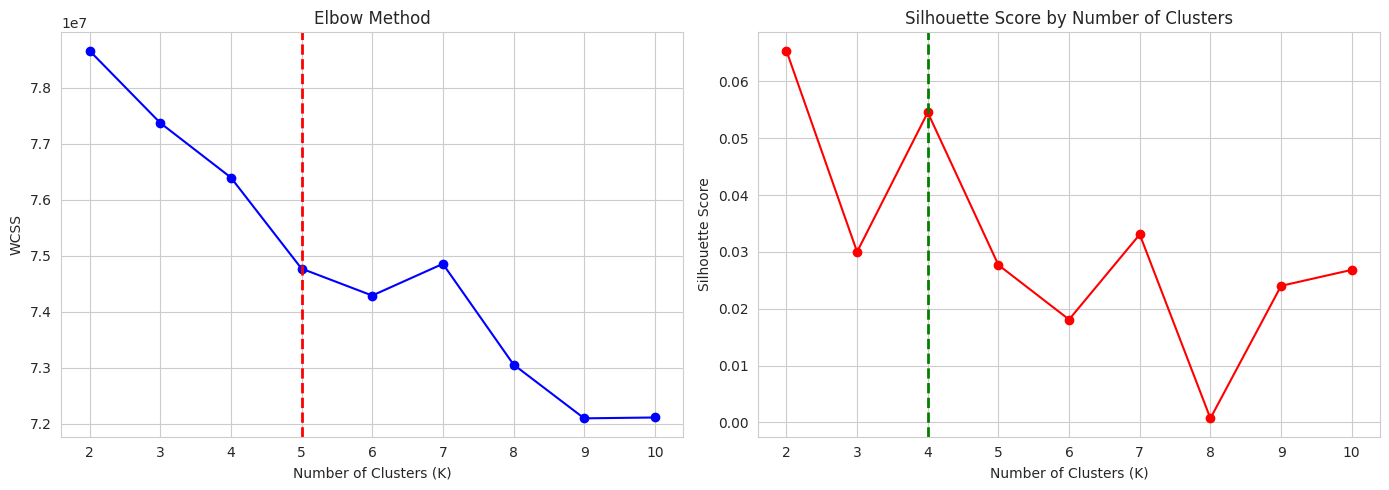

In [14]:
# Plot Elbow Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia plot
axes[0].plot(K_range, wcss, 'bo-')
axes[0].axvline(x=5, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('WCSS')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

# Silhouette score plot
axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].axvline(x=4, color='green', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by Number of Clusters')
axes[1].grid(True)

plt.tight_layout()
plt.show()

From the plots:
* **Elbow Method**: There is a noticeable drop in WCSS as you move from $K=2$ to $K=4$, and the curve starts to flatten out more significantly after $K=5$. This suggests that $K=5$ is s primary candidate for the "elbow."

* **Sihouette Score**: While $K=2$ has the highest score, $K=4$ provides a much more detailed and meaningful structure without losing cluster quality.

The optimal number of clusters is $K=4$. Therefore, we will proceed to fit the final KMeans model with 4 clusters.



## Train Final Segmentation Model

In [15]:
# Based on the elbow method
optimal_k = 4

print(f"Training K-Means with K={optimal_k} clusters...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the original data
df_segmented = df.copy()
df_segmented['Cluster'] = cluster_labels

print(f"Cluster distribution:")
print(pd.Series(cluster_labels).value_counts().sort_index())
print(f"\nPercentage distribution:")
print(pd.Series(cluster_labels).value_counts(normalize=True).sort_index() * 100)

Training K-Means with K=4 clusters...
Cluster distribution:
0    61381
1    73250
2     1516
3    63376
Name: count, dtype: int64

Percentage distribution:
0    30.763872
1    36.712559
2     0.759812
3    31.763757
Name: proportion, dtype: float64


In [19]:
print('Average High Income (%) for each cluster:')
income_potential = df_segmented.groupby('Cluster')['label'].apply(lambda x: (x.str.strip() == '50000+.').sum() / len(x) * 100)
print(income_potential)

Average High Income (%) for each cluster:
Cluster
0    8.512406
1    8.932423
2    0.000000
3    0.968821
Name: label, dtype: float64


## Visualize Clusters

PCA explained variance ratio: [0.03496964 0.02577121]
Total variance explained: 6.07%


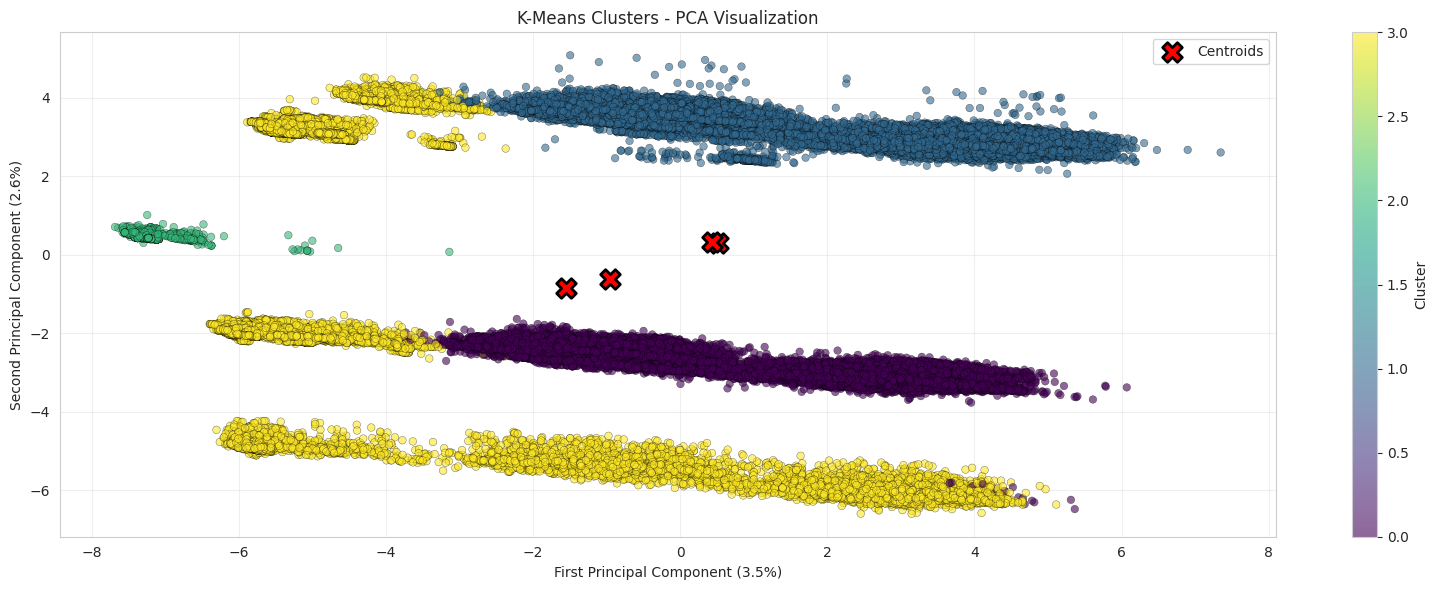

In [17]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Visualize clusters using PCA
fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# PCA
scatter1 = axes.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=cluster_labels, cmap='viridis',
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1],
               c='red', marker='X', s=200, edgecolors='black', linewidth=2, label='Centroids')
axes.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%})')
axes.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%})')
axes.set_title('K-Means Clusters - PCA Visualization')
axes.legend()
plt.colorbar(scatter1, ax=axes, label='Cluster')
axes.grid(alpha=0.3)

plt.tight_layout()
plt.show()

* The clear separation of the centroids in the plot confirms that the $K=4$ model successfully partitioned the data into four distinct segements that are visually separable in 2D. Cluster 0, 1, and 3 form the three largest, most distinct "bands" and Cluster 2, the minority group, is a very small "niche" segment the model successfully isolated.

* The band nature of the datapoints suggests your segments are defined heavily by specific categorical characteristics ather than just continuous numeric values.

## Compare Clusters Using Key Metrics

In [18]:
# Create comparison table across clusters
comparison_metrics = {}

for cluster_id in range(optimal_k):
    cluster_data = df_segmented[df_segmented['Cluster'] == cluster_id]

    # Calculate key metrics
    metrics = {
        'Population': len(cluster_data),
        'Avg Age': cluster_data['age'].mean(),
        'High Income %': (cluster_data['label'].str.strip() == '50000+.').sum() / len(cluster_data) * 100,
        'Avg Weeks Worked': cluster_data['weeks worked in year'].mean(),
        'Capital Gains %': (cluster_data['capital gains'] > 0).sum() / len(cluster_data) * 100,
        'Avg Education Years': cluster_data['education'].apply(lambda x: len(str(x))).mean()  # Proxy
    }
    comparison_metrics[f'Cluster {cluster_id}'] = metrics

comparison_df = pd.DataFrame(comparison_metrics).T
print(comparison_df.to_string())

           Population    Avg Age  High Income %  Avg Weeks Worked  Capital Gains %  Avg Education Years
Cluster 0     61381.0  45.893338       8.512406         31.074029         5.058569            22.633046
Cluster 1     73250.0  44.195904       8.932423         31.629706         5.201365            22.704819
Cluster 2      1516.0   0.000000       0.000000          0.000000         0.000000             8.000000
Cluster 3     63376.0  13.065782       0.968821          6.306709         0.732138            11.034209


* **Cluster 0**: Represents 30.8% of the market, with an average age 45.9. They work 31.1 weeks/year and are the second-highest earners, representing a reliable "Middle Market".

* **Cluster 1**: is the largest market population (36.7%), with an average age of 44.2 and are the highest earners, earning slightly more than Segment 0. Their work engagement work engagement is 31.6 weeks/year, making up the "Core Workforce/Primary Market"

* **Cluster 2**: This is the very specific "Niche" population (7.6%) that the model isolated. With an average age of 0, these are infants and newborns. While they are the smallest group, they represent a highly specific life stage for a household ('The Newborn Niche").

* **Cluster 3**: Representing nearly a third of population (31.8%), these are children and young teenagers with an average age of 13.1. Their low work engagement and income are expected because they are primarily in school, making up the "Junior Consumer Market".

## Improvement Opportunnities

*   To get even cleaner segments, we could try dropping more features like the `Country of Birth`and combine if they are not helping differentiate the high-income groups, as these are likely contributing to the low Silhouette Score. This will also help reduces the feature explosion from one-hot encoding.
*   We could take the total population in Clusters 0 and 1 and run a new K-Means model just on them to find the subtle differences in the "Core Workforce".
*   We could explore other alternative cluster algorithms like K-Prototypes, which is able to handle both numerical and categorical variables simultaneously without needing the 400-column one-hot encoding that is currently lowering our Silhouette Score.